# Sign Language Digits Recognition
Building a neural network to detect digits made by sign language using tensorflow.

In [1]:
# Clone the dataset from the original github repository. Run only once. Uncomment the line of code below.
# !git clone ‘https://github.com/ardamavi/Sign-Language-Digits-Dataset.git'

In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.contrib import layers
from sklearn.model_selection import train_test_split

In [3]:
dir = "Sign-Language-Digits-Dataset/Dataset"

def load_my_dataset(dir):
    '''
    loads dataset as input matrix, output vector and no of classes
    
    Arguments:
    dir -- path of the directory where the dataset is stored
    
    Returns: 
    images -- input matrix of dimension (no of examples, 64, 64, 3)
    label -- output vector of length (no of examples)
    no_classes -- number of classes in which the dataset is divided
    '''
    
    images = []
    label = []
    for foldername in os.listdir(dir):
        no_classes = len(os.listdir(dir))
        for filename in os.listdir(dir + '/' + foldername):
            img = Image.open(dir + '/' + foldername + '/' + filename)
            img.thumbnail((64,64), Image.ANTIALIAS)
            img = np.asarray(img)
            images.append(img)
            label.append(foldername)
    images = np.asarray(images)
    return images,label,no_classes

In [4]:
X,Y,C = load_my_dataset(dir)

y = 0


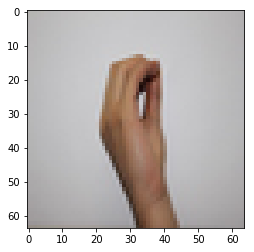

In [5]:
# dataset example
index = 2
plt.imshow(X[index])#, cmap = 'gray')
print ("y = " + str(Y[index]))

In [6]:
def one_hot_matrix(C, labels):
    '''
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column corresponds to the 
    jth training example. So if example j had a label i. Then entry (i,j) will be 1. 
                     
    Arguments:
    C -- number of classes, the depth of the one hot dimension
    labels -- vector containing the labels 
    
    Returns: 
    one_hot -- one hot matrix
    '''
    
    C = tf.constant(C, name = 'C')
    one_hot_matrix = tf.one_hot(labels, C)#, axis = 0)
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix)
    sess.close()
    return one_hot

In [7]:
def convert_and_split(X, Y, no_classes):
    '''
    converts dataset into training and testing matrices afterflattening and normalizing input matrix and 
    converting output vector into a one hot matrix.
    
    Arguments:
    X -- input matrix of dimension (no of examples, 64, 64, 3)
    Y -- output vector of length (no of examples)
    
    Returns: 
    x_train -- input training matrix of dimensions (12288, 1546)
    x_test -- input test matrix of dimensions (10, 1546)
    y_train -- output training matrix of dimensions (12288, 516)
    y_test -- output test matrix of dimensions (10, 516)
    '''
    
    X = X.astype(np.float32)
    flattened_x = X.reshape(X.shape[0], -1)
    label = one_hot_matrix(no_classes, np.array(Y))
    flattened_x = flattened_x / 255.
    x_train, x_test, y_train, y_test = train_test_split(flattened_x,label, test_size=0.25, random_state=58)
    return x_train.T, x_test.T, y_train.T, y_test.T

In [8]:
x_train, x_test, y_train, y_test = convert_and_split(X, Y, C)

In [9]:
print(type(x_train), type(y_train), type(x_test), type(y_test))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(x_train.dtype, y_train.dtype, x_test.dtype, y_test.dtype)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(12288, 1546) (10, 1546) (12288, 516) (10, 516)
float32 float32 float32 float32


In [10]:
def random_mini_batches(X, Y, minibatch_size = 64, seed = 0):
    '''
    splits the dataset (X,Y) into random mini batches
    
    Arguments:
    X -- input matrix
    Y -- output matrix
    minibatch_size -- size of minibatches to be made (default value = 64)
    seed -- seed value for random value generation (default value = 0) 
    
    Returns: 
    minibatches -- a list of tuples containing minibatches (input matrix, output matrix) of length minibatch_size
    '''
    
    m = X.shape[1]
    mini_batches = []
    np.random.seed(seed)
    
    permutation = list(np.random.permutation(m))
    shuffled_x = X[:, permutation]
    shuffled_y = Y[:, permutation]
    
    num_complete_minibatches = m // minibatch_size
    
    for n in range(0, num_complete_minibatches):
        mini_x = shuffled_x[:, n*minibatch_size : (n+1)*minibatch_size]
        mini_y = shuffled_y[:, n*minibatch_size : (n+1)*minibatch_size]
        minibatch = (mini_x, mini_y)
        mini_batches.append(minibatch)
    
    if m % minibatch_size != 0:
        mini_x = shuffled_x[:, num_complete_minibatches*minibatch_size : ]
        mini_y = shuffled_y[:, num_complete_minibatches*minibatch_size : ]
        minibatch = (mini_x, mini_y)
        mini_batches.append(minibatch)
    
    return mini_batches

In [11]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 9, so -> 10)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "tf.float32"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "tf.float32"
    
    Using 'None' because the number of examples during test/train is different, so it makes the placeholders flexible.
    """
    
    X = tf.placeholder(tf.float32, name=None, shape = (n_x,None))
    Y = tf.placeholder(tf.float32, name=None, shape = (n_y,None))
    return X, Y

In [12]:
def initialize_parameters(layer_dims, seed):
    """
    Initializes parameters to build a neural network with tensorflow

    Arguments:
    layer_dims -- a list containing different number of hidden units for each layer of the model. The size of the list is
                  the number of layers in the model
    seed -- seed value for random value generation (default value = 0) 
    
    Returns:
    parameters -- a dictionary of tensors containing weight and bias matrix for all layers according to the size of their
                  number of hidden units
    """
    
    tf.set_random_seed(seed)
    parameters = {}
    L = len(layer_dims) #total number of layers of the neural network
    for l in range(1,L):
        parameters['W' + str(l)] = tf.get_variable('W' + str(l), [layer_dims[l],layer_dims[l-1]], initializer = tf.contrib.layers.xavier_initializer(seed = seed))
        parameters['b' + str(l)] = tf.get_variable('b' + str(l), [layer_dims[l],1], initializer = tf.zeros_initializer())
    return parameters

In [13]:
def forward_pass(X, parameters, activation):
    """
    Implements the forward propagation for the model according to their provided activation functions (sigmoid or relu)
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- a dictionary of tensors containing weight and bias matrix for all layers according to the size of their
                  number of hidden units
    activation -- list containing the activation functions for each layer
    
    Returns:
    Z -- the output of the last LINEAR unit. The output after applying activation (A) to this last Linear unit is not returned
         because in tensorflow, the cost is calculated with the output of Z, so the last A is of no use.
    """
    
    L = len(activation)
    A_prev = X
    for l in range(L):
        W = parameters['W' + str(l+1)]
        b = parameters['b' + str(l+1)]
        Z = tf.add(tf.matmul(W, A_prev),b)
        if activation[l] == 'sigmoid':
            A = tf.sigmoid(Z)
        elif activation[l] == 'relu':
            A = tf.nn.relu(Z)
        A_prev = A
    return Z

In [14]:
def compute_cost(Z3, Y, parameters, lambd):
    """
    Computes the cost
    
    Arguments:
    Z -- output of forward propagation (output of the last LINEAR unit), of shape (10, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z
    parameters -- a dictionary of tensors containing weight and bias matrix for all layers according to the size of their
                  number of hidden units
    lambd -- regularization parameter for L2 regularization
    
    Returns:
    cost - Tensor of the cost function
    """
    
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels))
    
    regularization_term = 0
    for i in range(len(parameters)//2):
        W = parameters['W' + str(i+1)]
        regularization_term = regularization_term + tf.nn.l2_loss(W)
    regularization_cost = lambd * regularization_term
    cost = cost + regularization_cost
    return cost

In [15]:
def model(x_train, y_train, x_test, y_test, layer_dims, activation, num_epochs = 1500,
          learning_rate = 0.0001, minibatch_size = 32, lambd = 0.01, print_cost = True):
    """
    Implements a tensorflow neural network
    
    Arguments:
    x_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    x_test -- training set, of shape (input size = 12288, number of training examples = 120)
    y_test -- test set, of shape (output size = 6, number of test examples = 120)
    layer_dims -- a list containing different number of hidden units for each layer of the model. The size of the list is
                  the number of layers in the model
    activation -- list containing the activation functions for each layer
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    lambd -- regularization parameter for L2 regularization
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = x_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = y_train.shape[0]                            # n_y : output size
    layer_dims.insert(0,n_x)
    costs = []                                        
    
    # Create Placeholders
    X, Y = create_placeholders(n_x,n_y)
    # Initialize parameters
    parameters = initialize_parameters(layer_dims, 1)
    # Forward propagation
    Z = forward_pass(X, parameters, activation)
    # Cost function
    cost = compute_cost(Z, Y, parameters, lambd)
    # Backpropagation
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)   # using Adam optimizer

    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        # Training
        for epoch in range(num_epochs):
            
            epoch_cost = 0.     
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(x_train, y_train, minibatch_size, seed)

            # learning rate decay not working correctly, will update later.
            
                #if epoch % 100 == 0:
                #    learning_rate = learning_rate - 0.0001    
            
            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict = {X : minibatch_X, Y : minibatch_Y})
                
                epoch_cost = epoch_cost + minibatch_cost / minibatch_size

            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plotting the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # saving trained parameters in a variable to use in prediction
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions and accuracy
        correct_prediction = tf.equal(tf.argmax(Z), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: x_train, Y: y_train}))
        print ("Test Accuracy:", accuracy.eval({X: x_test, Y: y_test}))
        
        return parameters

Instructions for updating:
Colocations handled automatically by placer.
Cost after epoch 0: 4.098582
Cost after epoch 100: 1.954266
Cost after epoch 200: 1.586852
Cost after epoch 300: 1.334112
Cost after epoch 400: 1.180983
Cost after epoch 500: 1.069922
Cost after epoch 600: 0.984190
Cost after epoch 700: 0.938523
Cost after epoch 800: 0.891954
Cost after epoch 900: 0.850168


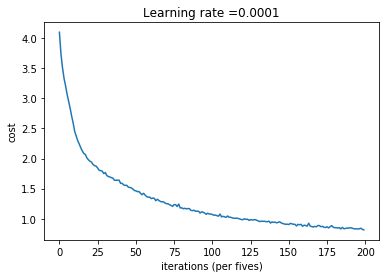

Parameters have been trained!
Train Accuracy: 0.9592497
Test Accuracy: 0.79651165


In [16]:
# HYPERPARAMETERS
layer_dims = [25,15,10] # number of units in the hidden layers and the output layer
activation = ['relu','relu','relu'] # activation
num_epochs = 1000

# IMPLEMENTING THE MODEL
parameters = model(x_train, y_train, x_test, y_test, layer_dims, activation, num_epochs)

In [17]:
# The model is overfitting currently. I used L2 regularization to remove overfitting to a certain extant.
# The test set accuracy with no regularization (lambd = 0) was 0.75.
# The test set accuracy with regularization (lambd = 0.001 and 0.01) was almost 0.796.
# Further overfitting needs to be reduced, will update later.